# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 4000

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    4000
ID           4000
Time         4000
none         4000
username     4000
Text         4000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['@StewartWade Yeah, I know--pigs for sure...which is a great visual on my end among all the akimbo-ness. ',
       "ouh @Babe_Franzi was hast du hun'? hoffentlich nichts schlimmes. yes, i miss you rlly much, mary too. ",
       'Woke up with the worst headache ',
       "@MacekMakeupArt I can't remember the last movie I saw in a theatre!  Hope you guys have fun! What are you going to see?",
       'last day of classes   im going to miss chichi !',
       'Damn, time for another pedicure, just chipped my toenail on an open cabinet  Shit happens!',
       "@mikegentile i've never been in a walmart  no joke",
       "@amedelrivero Start putting up $100 every paycheck! We have to prepare ourselves for the future -_-. ONLY $300 is what i'm getting ",
       '@patrickeatworld takboleh. i am so in loveeeeeeeeeeee  life sucks. FMMFL',
       'I have church thur and am always forgetting I can watch fbc on line until Thurs. '],
      dtype=object)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 798000
processed: 799000
processed: 800000
processed: 801000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week"
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,That's awful. I wish mine would stop making fat jokes.
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life"
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch."
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 798000
processed: 799000
processed: 800000
processed: 801000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week",work slow im seriously considering quitting job week
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,That's awful. I wish mine would stop making fat jokes.,thats awful wish mine would stop making fat jokes .
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life",well guess need start new chapter professional life
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.",miss lady since brought web store notoriously known takes ages rec ' v merch .
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,im sorry hope u feel better cuz love u makes feel horrible ur sick sad mad hurt
...,...,...,...,...,...,...,...,...
801994,4,1468163268,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,jerichoK,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,Five? Seems a little bit too late in the morning but what the hell !,five seems little bit late morning hell
801995,4,1468163291,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,ex1up,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [.. http://tinyurl.com/c3e3ub,ryanodonnell: Thanks for putting on such a great event. Can't wait for the inevitable sequels! [..,ryanodonnell thanks putting great event ' wait inevitable sequels ! [..
801996,4,1468163300,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,Mmmbaileys,@damygeebo Carli's my friend,Carli's my friend,carlis friend
801997,4,1468163315,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,jasminejoejonas,I feel so great for starting twitter at suzanne but still hardly anyone has it.,I feel so great for starting twitter at suzanne but still hardly anyone has it.,feel great starting twitter suzanne still hardly anyone


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

798000
799000
800000
801000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week",work slow im seriously considering quitting job week,work slow -PRON- be seriously consider quit job week,work job week,slow,be consider quit,work job week slow be consider quit,9.00
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,That's awful. I wish mine would stop making fat jokes.,thats awful wish mine would stop making fat jokes .,that s awful wish mine would stop make fat joke .,wish mine joke,awful fat,s would stop make,wish mine joke awful fat s would stop make,11.00
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life",well guess need start new chapter professional life,well guess nee start new chapter professional life,chapter professional life,new,guess nee start,chapter professional life new guess nee start,8.00
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.",miss lady since brought web store notoriously known takes ages rec ' v merch .,miss lady since bring web store notoriously know take age rec ' v merch .,miss lady web store age rec v merch,,bring know take,miss lady web store age rec v merch bring know take,15.00
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,im sorry hope u feel better cuz love u makes feel horrible ur sick sad mad hurt,-PRON- be sorry hope u feel better cuz love u make feel horrible ur sick sad mad hurt,hope love hurt,sorry horrible sick sad mad,be feel make feel,hope love hurt sorry horrible sick sad mad be feel make feel,18.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801994,4,1468163268,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,jerichoK,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,Five? Seems a little bit too late in the morning but what the hell !,five seems little bit late morning hell,five seem little bit late morning hell,bit morning hell,little late,seem,bit morning hell little late seem,7.00
801995,4,1468163291,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,ex1up,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [.. http://tinyurl.com/c3e3ub,ryanodonnell: Thanks for putting on such a great event. Can't wait for the inevitable sequels! [..,ryanodonnell thanks putting great event ' wait inevitable sequels ! [..,ryanodonnell thank put great event ' wait inevitable sequel ! [ ..,ryanodonnell thank event sequel,great inevitable,put wait,ryanodonnell thank event sequel great inevitable put wait,12.00
801996,4,1468163300,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,Mmmbaileys,@damygeebo Carli's my friend,Carli's my friend,carlis friend,carlis friend,carlis friend,,,carlis friend,2.00
801997,4,1468163315,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,jasminejoejonas,I feel so great for starting twitter at suzanne but still hardly anyone has it.,I feel so great for starting twitter at suzanne but still hardly anyone has it.,feel great starting twitter suzanne still hardly anyone,feel great start twitt suzanne still har

# Sometimes, our cleaning reduces our text to nothing! Which makes a lot of stuff unable to run.

## This hack has been helpful in that regard:

In [26]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# df = df.sample(frac=1)

sentiment          3974
ID                 3974
Time               3974
none               3974
username           3974
Text               3974
text_clean         3974
text_normalized    3974
text_lemma         3974
text_nouns         3974
text_adjectives    3974
text_verbs         3974
text_nav           3974
no_tokens          3974
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [27]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [28]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

4    1989
0    1985
Name: sentiment, dtype: int64

Good. Seems balanced enough for now.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,3974.00,2.00,2.00,0.00,0.00,4.00,4.00,4.00
ID,3974.00,1897965100.15,430453592.83,1467822272.00,1468005635.00,1468163307.50,2328798351.25,2329205794.00
no_tokens,3974.00,8.68,5.21,1.00,5.00,8.00,12.00,38.00


### Exploring text at different levels of cleaning

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
801130,day is almost over! i can't wait to eat wade...hehe...,day almost cant wait eat wade ... hehe ...,day almost can not wait eat wade ... hehe ...,day wade can wait eat
799157,Lmaoooo im so sorry and i spoke to u yesterday! completely slipped my mind.. i sowwy,lmaoooo im sorry spoke u yesterday completely slipped mind . sowwy,lmaoooo -PRON- be sorry speak u yesterday completely slip mind . sowwy,lmaoooo sorry u yesterday mind be speak slip sowwy
799574,"it is a good weather out today, we should chill, but first, come to broadway with me anyoneeeee ?!","good weather today chill first , come broadway anyoneeeee ?!","good weather today chill first , come broadway anyoneeeee ? !",weather today chill broadway anyoneeeee good come
798205,"Woke up with my head feeling like it'd been split in two, generally feeling icky today. I hope I didn't catch Sage's cold.",woke head feeling like itd split two generally feeling icky today . hope ' catch sage ' cold .,wake head feel like -PRON- would split two generally feel icky today . hope ' catch sage ' cold .,head today hope catch sage cold icky wake feel would split feel
801336,"Night all, back for more tomorrow",night back tomorrow,night back tomorrow,night tomorrow
801204,"It's my view, not yours -- yours is the same",view --,view --,view
799697,Dammmn! Travel man! I'm in the DMV. Birthday is tomorrow that's y I asked ... Miami tho. Who you going with? Watts,dammmn travel man ' dmv . birthday tomorrow ' asked ... miami tho . going ? watts,dammmn travel man ' dmv . birthday tomorrow ' ask ... miami tho . go ? watts,dammmn travel man dmv birthday tomorrow miami tho ask go
801714,Watching funny TV show clips on Hulu.com,watching funny tv show clips hulucom,watch funny tv show clip hulucom,tv clip funny watch show
799403,elle <---sadder face cause you leaving and we never hooked up,elle -- sadder face cause leaving never hooked,elle -- sad face cause leave never hook,elle face cause sad leave hook
798552,So so sad about Farrah Fawcett... My heart goes out to her family! RIP,sad farrah fawcett . heart goes family ! rip,sad farrah fawcett . heart go family ! rip,farrah fawcett heart family sad go


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['work', 'job', 'week', 'slow', 'be', 'consider', 'quit', 'wish', 'mine', 'joke', 'awful', 'fat', 's', 'would', 'stop', 'make', 'chapter', 'professional', 'life', 'new', 'guess', 'nee', 'start', 'miss', 'lady', 'web', 'store', 'age', 'rec', 'v', 'merch', 'bring', 'know', 'take', 'hope', 'love', 'hurt', 'sorry', 'horrible', 'sick', 'sad', 'mad', 'be', 'feel', 'make', 'feel', 'know', 'pig', 'end', 'akimbo', 'ness', 'sure', 'great', 'visual', 'ouh', 'franzi', 'hast', 'du', 'hun', 'hoffentlich', 'nicht', 'schlimme', 'miss', 'mary', 'headache', 'bad', 'wake', 'movie', 'theatre', 'hope', 'guy', 'fun', 'last', 'can', 'remember', 'see', 'go', 'see', 'day', 'class', 'miss', 'chichi', 'last', 'be', 'go', 'time', 'pedicure', 'cabinet', 'shit', 'damn', 'open', 'chip', 'toenail', 'happen', 'walmart', 'joke', 'have', 'paycheck', 'future', 'start', 'put', 'prepare', 'get', 'takboleh', 'life', 'fmmfl', 'loveeeeeeeeeeee', 'suck', 'church', 'thur', 'watch', 'fbc', 'line', 'thur', 'forget', 'yikes', 'hay

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 454),
 ('go', 386),
 ('fawcett', 335),
 ('be', 305),
 ('good', 282),
 ('get', 276),
 ('sad', 261),
 ('day', 238),
 ('work', 200),
 ('love', 189),
 ('today', 175),
 ('miss', 166),
 ('time', 162),
 ('see', 150),
 ('rip', 150),
 ('die', 146),
 ('know', 145),
 ('make', 144),
 ('quot', 141),
 ('want', 139)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'go', 'fawcett', 'be', 'good', 'get', 'sad', 'day', 'work', 'love', 'today', 'miss', 'time', 'see', 'rip', 'die', 'know', 'make', 'quot', 'want', 'think', 's', 'feel', 'thank', 'night', 'morning', 'pass', 'new', 'can', 'would', 'hope', 'say', 'come', 'watch', 'twitter', 'need', 'rest', 'angel', 'take', 'u', 'peace', 'lol', 'tomorrow', 'last', 'try', 'look', 'bad', 'cancer', 'great', 'bed', 'sleep', 'friend', 'wish', 'tonight', 'start', 'find', 'happy', 'hear', 'could', 'week', 'life', 'guy', 'fun', 'thing', 'wait', 'leave', 'show', 'hour', 'way', 'nice', 'man', 'may', 'much', 'people', 'news', 'let', 'lose', 'hate', 'family', 'tell', 'have', 'use', 'long', 'eat', 'give', 'tweet', 'guess', 'do', 'read', 'break', 'year', 'sorry', 'suck', 'school', 'talk', 'glad', 'call', 'awesome', 'charlie', 'hot', 'beautiful', 'hair', 'head', 'home', 'little', 'well', 'big', 'many', 'mean', 'ill', 'help', 'yay', 'god', 'house', 'keep', 'late', 'cool', 'lot', 'hurt', 'sound', '#', 'first', 'p

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

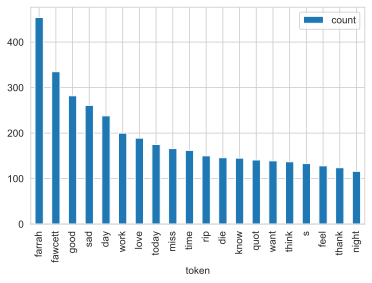

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

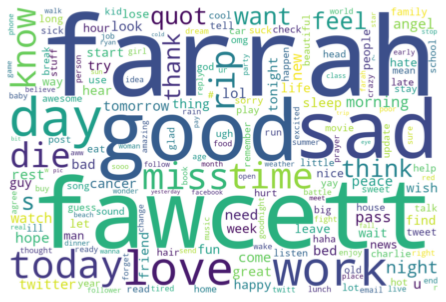

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

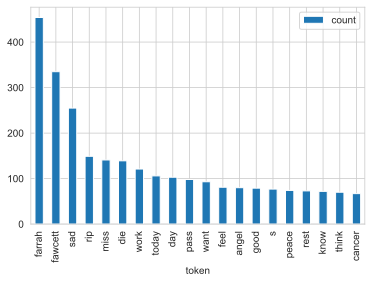

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

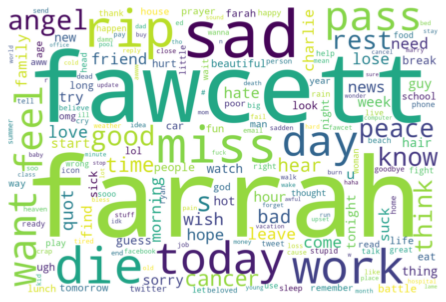

In [46]:
wordcloud(neg_counter)

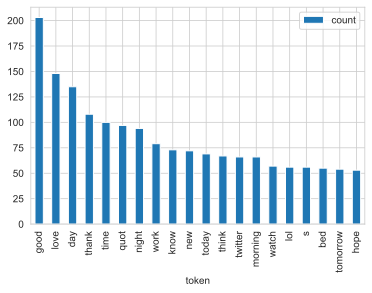

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

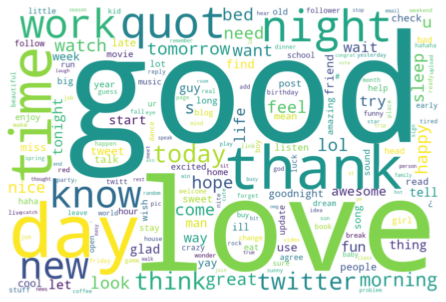

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

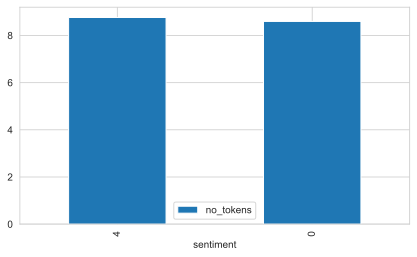

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

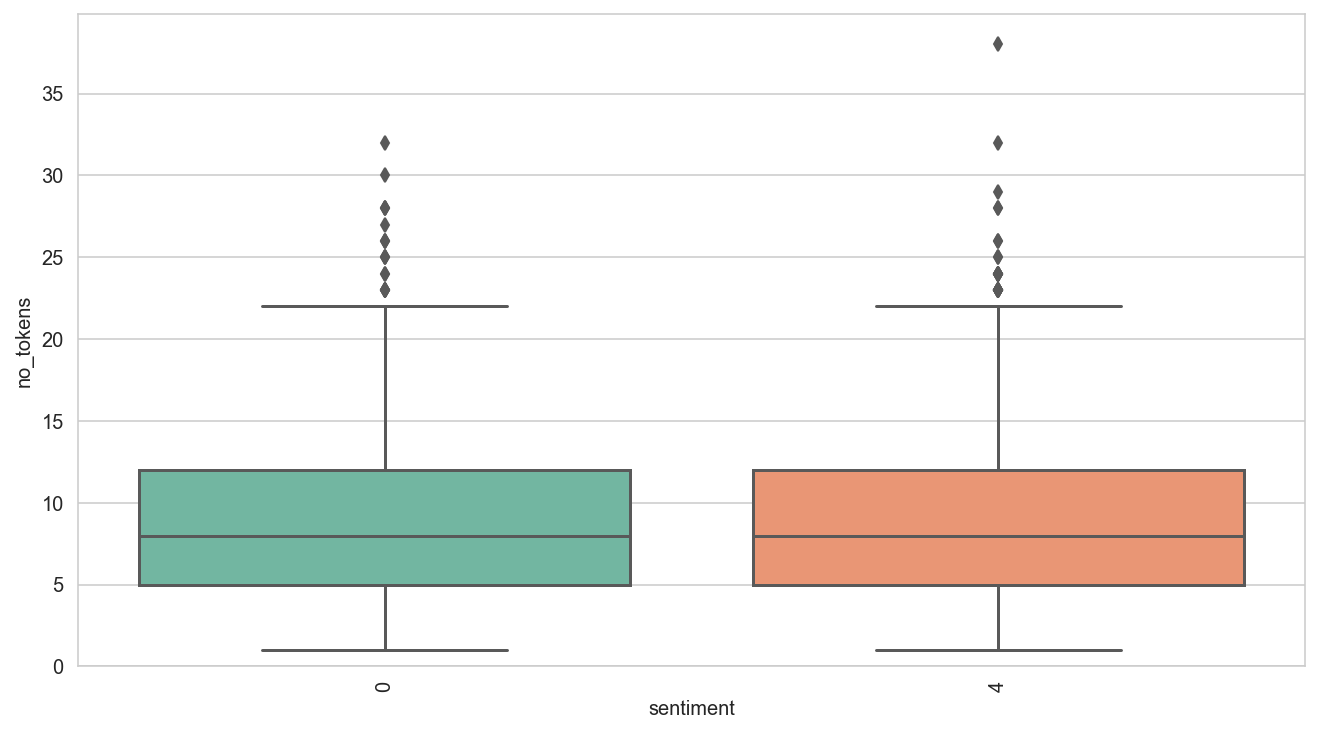

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaaaahhhh,aaaand,aaargh,aaawwww,aargh,aaru,abay,abby,abc,abdul,ability,abit,able,absolute,absorb,...,zippy,zoe,zombie,zone,zoo,zta,½c,½i,½n,½o,½s,½se,½y,½ï,ï¾
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0,

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,age,akimbo,awful,bad,be,bring,can,chapter,chichi,class,day,du,end,fat,feel,...,schlimme,see,sick,sorry,start,stop,store,sure,take,theatre,visual,wake,web,wish,would
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aaaaahhhh zippy,aaaaahhhh zippy next,aaaaahhhh zippy next do,aaaaahhhh zippy next do stop,aaaand portfolio,aaaand portfolio time,aaaand portfolio time enough,aaaand portfolio time enough make,aaargh cold,aaargh cold fine,aaargh cold fine add,aaargh cold fine add be,aaawwww farrah,aaawwww farrah ri,aaawwww farrah ri die,...,½s xd day school today,½se auf,½se auf toast,½se auf toast germandoo,½se auf toast germandoo joy,½y bay,½y bay ½n,½y bay ½n ng,½y bay ½n ng ch,½ï ½ï,½ï ½ï ½ï,ï¾ tomorrow,ï¾ tomorrow go,ï¾ tomorrow go say,ï¾ tomorrow go say will
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,age rec,akimbo ness,awful fat,bad wake,be feel,be go,bring know,can remember,chapter professional,chichi last,class miss,day class,du hun,end akimbo,fat would,...,professional life,rec merch,remember see,sad mad,schlimme miss,see go,sick sad,sorry horrible,stop make,store age,sure great,theatre hope,web store,wish mine,would stop
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aaaaahhhh,aaaand,aaargh,aaawwww,aargh,aaru,abay,abby,abc,abdul,ability,abit,able,absolute,absorb,...,zippy,zoe,zombie,zone,zoo,zta,½c,½i,½n,½o,½s,½se,½y,½ï,ï¾
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3970,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3971,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3972,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,age,akimbo,awful,bad,be,bring,can,chapter,chichi,class,day,du,end,fat,feel,...,schlimme,see,sick,sorry,start,stop,store,sure,take,theatre,visual,wake,web,wish,would
0,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.36,0.00,...,0.00,0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.36,0.36
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.33,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.33,0.00,0.00,0.00,0.33,0.00,0.00
3,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.55,...,0.00,0.00,0.28,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.36,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.36,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,...,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.42,0.42,0.42,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  12,   18,   19,   39,   43,   44,   73,   79,   86,  102,  148,  169,
        176,  182,  184,  185,  187,  211,  221,  237,  243,  275,  287,  288,
        298,  305,  310,  311,  316,  318,  321,  337,  345,  349,  368,  372,
        389,  407,  426,  429,  431,  442,  447,  458,  464,  465,  487,  517,
        522,  525,  554,  563,  587,  594,  601,  602,  611,  613,  617,  618,
        643,  654,  656,  658,  680,  686,  694,  695,  705,  731,  760,  764,
        766,  781,  797,  800,  825,  848,  852,  859,  867,  883,  903,  949,
        957,  965,  970,  975,  987,  996, 1001, 1008, 1012, 1014, 1016, 1018,
       1028, 1033, 1035, 1042, 1044, 1070, 1072, 1076, 1099, 1105, 1107, 1114,
       1126, 1128, 1134, 1152, 1162, 1181, 1192, 1208, 1221, 1222, 1231, 1241,
       1243, 1248, 1264, 1271, 1308, 1309, 1313, 1315, 1318, 1344, 1345, 1350,
       1363, 1378, 1382, 1398, 1401, 1402, 1416, 1422, 1440, 1448, 1454, 1456,
       1467, 1474, 1507, 1515, 1519, 1520, 1527, 159

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [64]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

able accept access actress add addict age agree ahhh airport amazing angel animal anne anniversary announce annoying app appreciate arm arrive attend aunt aussie avatar awake awesome awful aww awww awwww back bad bag band bank battle beach bed bedtime beer believe beloved bet beyonce bf birthday blib blog blonde boo boooo bottle bowl boy boyfriend brand brave break breakfast britney broken brother brown bug building bummed bummer burn bye can cancel cancer car carradine carter celeb chance chapel charlie check chicago chocolate classy client close club cnn coffee college com comin commercial common community company computer concert condolence congrat congratulation cook cookie cool count couple courageous cousin crap crappy crazy cross cry cure cute dad dance dancing dark date daughter day dead death depress depressed deserve design desire die diego different direct disease disney dm do doc dollar donnie dougie drag dread dream drinking drug dvd early easter easy ed enjoy enter errand

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [66]:
model = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [3192 1045 2992 ... 3103   18 3672]


In [67]:
i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

able access add addict afraid age agree ahhh air airport amazing andy angel anne annoying answer app appreciate arm arrive aunt avatar awake awesome awful aww awww awwww baby back bad bag band bank battle bc be beach bed bedtime beer begin believe beloved bet big bill birthday blib blog boo book boooo bottle bout bowl boy boyfriend brand break breakfast broken bug burn busy bye can cancel cancer car carter cause chance change charlie check chicago chill chocolate client close club coffee college com come comin community company computer condolence congrat congratulation cookie cool count couple cousin crap crappy crazy cross cry cut cute da dad damn dance date day dead depress deserve die different do dog dollar dread dream drinking dude dvd early easter easy eat ed email english enjoy enter evening exam excite excited facebook fail family farah farrah fast fat fawcet fawcett feather feature feed feel fight fine first flag follow follower food freakin friday friend fuck fun fund funera

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [68]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 5.34e-05 8.71e-06 ... 0.00e+00 2.04e-06 5.36e-05]


In [70]:
i=0
n=0
min_imp = 0.00041
min_starred = 0.004
for x in model_bagged.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

able access add age agree ahhhh airport amazing angel anne app arm austin awesome awful aww baby back bad bag battle bc be beach bed begin beloved bestie big birthday bit blog boo book booooys boy boyfriend brand break broken bug burn bus buy bye call can cancel ***cancer car care carter cat catstropy cause change channel ***charlie check chicago chickening chocolate city class close clue cold college come comin company complete computer condition condolence confuse congrat contest cookie cool could course crap crappy crazy cross cry cus cut cute da dad dam damn darle ***day dead depress deserve ***die different dinner do doctor drink drop dude dumps early easy eat email end english enjoy enough enter errand essay ethnobotany excited exhausted facebook fail family fan farah ***farrah faucett favorite fawcet ***fawcett feature feel find first fly follow follower food football forget forgot free friday friend fro fry fuck full fun funny ***get gig girl give glad gmail go god ***good good

## Note that the stars ( *** ) denote features that were given much higher importances.

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [71]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([  12,   19,   39,   43,   73,   79,   86,  102,  148,  150,  169,  182,
        184,  185,  187,  193,  209,  211,  221,  237,  243,  275,  288,  298,
        305,  310,  311,  315,  316,  321,  337,  345,  349,  368,  389,  407,
        417,  426,  429,  431,  442,  447,  458,  465,  487,  517,  522,  525,
        554,  562,  601,  602,  611,  613,  615,  617,  618,  643,  654,  656,
        658,  686,  694,  695,  705,  760,  764,  766,  781,  796,  797,  800,
        809,  825,  848,  859,  867,  883,  903,  928,  949,  957,  965,  970,
        975,  987,  996, 1008, 1012, 1014, 1016, 1018, 1028, 1033, 1035, 1040,
       1042, 1044, 1070, 1072, 1076, 1099, 1105, 1107, 1114, 1126, 1128, 1134,
       1152, 1162, 1178, 1181, 1192, 1208, 1214, 1221, 1222, 1231, 1241, 1243,
       1264, 1271, 1273, 1308, 1309, 1313, 1315, 1318, 1344, 1345, 1350, 1363,
       1378, 1382, 1398, 1400, 1416, 1422, 1440, 1448, 1454, 1456, 1467, 1474,
       1507, 1515, 1519, 1520, 1527, 1589, 1590, 159

In [72]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

able access actress add age agree ahhh airport amazing american angel anne anniversary announce annoying answer apologize app appreciate arm arrive attend aussie avatar awake awesome awful awsome aww awwww back bad bag band battle beach beautiful bed bedtime beer believe beloved bet bf birthday blib blog blonde boo booo boy boyfriend brand brave brb break breakfast britney broken brother brown building bummed bummer burn can cancel cancer car carpet carradine carter cat celeb chance charlie check chicago chocolate cider classy client close club cnn coffee college comin commercial common community company computer concert condolence confuse congrat congratulation cook cookie cool count couple courageous cousin crap crappy crazy cross cry cupcakes cure cute dad dam dance dancing dark date daughter dead death debbs depress depressed deserve design desire die diego different direct disease disney dm dnt dollar donnie dougie drag dread dream drinking drug dvd early easter easy ed english en

## RFE on TF-IDF vectors 

In [73]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model_tfidf, 500)
fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [3192 1045 2992 ... 3103   18 3672]


In [74]:
i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

able access actress add addict afraid age agree ahhh air airport amazing angel anne annoying answer app appreciate arm arrive asleep avatar awake awesome awful aww awww awwww back bad bag band battle bc be beach beautiful bed bedtime beer begin believe beloved bet big birthday blib blog boo bout boy boyfriend brand break broken brother brown bug bummed burn busy buy can cancel cancer car carter cat cause chance change charlie check chicago chill chocolate close cnn coffee cold college color comin common company computer condolence confuse congrat congratulation cookie cool count couple course cousin crap crappy crazy cross cry cupcakes cut cute da dad dam damn dance date daughter day dead death debbs depress depressed deserve die different direct do dog dollar dougie dread dream drink drinking dude dvd early easter easy eat ed english enjoy enter errand essay evening excite excited exciting facebook fail fake family farah farrah fast faucett fawcet fawcett feather feature feel fight fi

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [75]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[1.31e-06 8.65e-05 8.51e-06 ... 2.23e-07 8.82e-07 4.82e-05]


In [76]:
i=0
n=0
min_imp = 0.00040
min_starred = 0.003
for x in model_bagged_tfidf.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

able actress add age agree ahhhh air amazing ***angel annoying anounced apettite app appreciate arm art austin awesome awful aww baby back ***bad battle bc ***be beach ***bed beloved big bit blog boo boooo booooys bored boy boyfriend break broken bug bummed burn bus busy buy bye call ***can cancel ***cancer car card care cat catch catstropy cause chance change ***charlie check chicago chickening chocolate city class close clue cold college come comin complete computer condition condolence confuse congrat contest cool could couple coursework crap crappy cry cus cut cute da dad dam damn darle ***day dead death depress ***die dinner do doctor dog doubt drop dumps early eat email end endless english enjoy enough enter errand ethnobotany excited exhausted facebook fail fall family fan farah ***farrah favorite fawcet ***fawcett ***feel fell fella fellow fight figure find first flag fly follow food football forget free friday friend fritz fry fuck full fun funeral funny gas ***get gig girl gi

# A record and summary of 6 types of Feature Selection

## Because I WILL be dropping RFE for being too intensive.

### Running with 3000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport amazing american angel animal anne anniversary announce answer appreciate arm arrive attend awesome awful aww awww back bad battle beach beautiful bed bedtime beer believe beloved beyonce birthday blog blonde blue boo book boy boyfriend brand brave britney bro ... tomorrow tongue toooo tragic trust tt tuesday tweet twilight twin twit twitter ugh ughhh unc unfair update updates upgrade upload upset ur use vacuum vegas version voice vote wait walters want warped wat watch way wayne website welcome window wish woke woman wonderful woop work wrist wrong wtf xd xoxo yay young youth yup
#### RFE with Bag of Words
aargh account add addict address afraid age agree ahhh air airport album amazing angel anniversary answer app arm arrive artistic attack attend attention awesome awful awsome aww baby back bad bag battle bc beach bed bet big birthday bit blib blog blue bonjour boo bore bored boy boyfriend brain brand break ... tragic true trust tuesday tv tweeting twin twit twitter ugh unc understand unfair updates upgrade upload upset vacation vegas version vibe video vote wait walmart wanna want wat watch way wayne welcome whole whyyyy wife win wish woke wonder wonderful woop word work working world write wrong wtf xavier xd yay young yup
#### Extra Trees Forest with Bag of Words
able account add addict afraid age agree ahhhh air album alex amazing angel apettite arm art audrey awesome awful aww baby back bad bag battle bc be beach beautiful bed begin beloved big bit blaaaaarg blache blog boo bore boy boyfriend break bubba bug burn bus bye call can cancel cancer car care cat cause ... twitter ugh ughh uncle unfair unusual upgrade upgradeable upload upset upsetting ur use vacation vibe vote wait wake walk wanna want warm warning watch way weather wee week weekend welcome well wholee will wish wishing woke woman wonderful work working world would wrong xoxo yay yeanot year yesterday young yup zoo
#### SelectKBest with TF-IDF
account actress add adore age agree ahaha ahhh airport amazing american anal angel anne anniversary announce annoying answer apologize appreciate arm arrive attend awesome awful awsome aww back background bad bag battle beach beautiful beauty bed bedtime beer beie believe beloved bestie beyonce birthday ... touchy tragic trust tuesday tweetie twilight twin twit twitt twitter ugh ughhh unc uncle understand unfair updates upload upset upsetting use va vegas version view voice vote wait wallpaper want watch way website welcome westney window wish woke woman wonderful woo work wrong xd xoxo yay yayyy young youth yup zoo 
#### RFE with TF-IDF
able account add address afraid age agree ahhh airport album amazing american angel anne anniversary answer appreciate arm arrive art attention awesome awful awsome aww back background bad bag battle bc be beach bed believe big birthday bit blog blue bonjour boo book bore bout boy boyfriend brand brb break bro ... upsetting va vacation vegas version vibe vote wait walk wanna want watch way wee welcome whole window wish wishing woke wonder wonderful word work working world wrong wtf xoxo yay young yud yup zoo
#### Extra Trees Forest with TF-IDF
able actress add addict afraid age agree ahhhh airport alex amazing andrewcilley angel apettite arm art awesome awful aww baby back bad battle bc be beach beautiful bed believe beloved big bit blaaaaarg blache blackberrys blog boo book bore bowls boy boyfriend break brussels bubba bug bunny burn butterfly ... upgrade upgradeable upload upset upsetting ur use vacation vegas vibe video wait wake walk walmart wanna want warm warning watch way weather wee week weekend welcome well whole wholee will window wish wishing woke woman wonderful word work working world worried would wrong xoxo yay yeanot year yesterday young yud yup yuri zoo  



## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [77]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector_ngrams = SelectKBest(chi2, k=400)
selected_features_ngrams = \
ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_ngrams

array([  191,   197,   229,   382,   875,   885,   886,   887,   922,   923,
         950,   992,   993,   994,  1007,  1948,  2018,  2022,  2317,  2401,
        2684,  2723,  2891,  2913,  3088,  3099,  3229,  3393,  3465,  3589,
        3595,  3616,  3617,  4225,  4970,  5895,  5899,  5904,  5917,  5972,
        5982,  6028,  6075,  6125,  6165,  6846,  6860,  6861,  6884,  6885,
        6886,  6890,  8540,  8581,  8626,  9967, 10012, 10135, 10229, 10717,
       10727, 10745, 11840, 11910, 11950, 11975, 11979, 11980, 13205, 13215,
       13266, 13404, 13515, 13531, 13549, 13565, 13569, 13577, 13578, 13579,
       13594, 13595, 13621, 13624, 13637, 13653, 13654, 13674, 13689, 13690,
       13733, 13748, 13750, 13753, 13776, 13827, 13835, 13838, 13847, 13868,
       13870, 13906, 13911, 13918, 13924, 13932, 13935, 13943, 13945, 13969,
       13972, 13973, 13974, 13991, 14010, 14024, 14047, 14210, 14219, 14228,
       14447, 14458, 14470, 14471, 14472, 14473, 14496, 14497, 14537, 14541,

In [78]:
for x in selected_features_ngrams:
    print(vocab_ngrams[x], end=' -       - ')

actress farrah -       - actress farrah fawcett -       - add thank -       - age sad -       - angel angel -       - angel beloved -       - angel beloved rip -       - angel beloved rip pass -       - angel farrah -       - angel farrah fawcett -       - angel heaven -       - angel quot -       - angel quot cancer -       - angel quot cancer die -       - angel sad -       - aww farrah -       - awww farrah -       - awww farrah fawcett -       - bad feel -       - bad want -       - battle cancer -       - battle cancer sad -       - be die -       - be get -       - be use -       - be watch -       - beautiful rip -       - bed night -       - bed tomorrow -       - believe die -       - believe pass -       - beloved rip -       - beloved rip pass -       - blog post -       - break die -       - can believe -       - can believe die -       - can believe pass -       - can go -       - can wait -       - can wait see -       - cancer age -       - cancer die -       - cancer li

time bed -       - time good -       - time last -       - time many -       - time night -       - time sad -       - time zone -       - tipsy afternoon -       - tipsy afternoon thank -       - tipsy afternoon thank leaving -       - tipsy afternoon thank leaving sad -       - tired be -       - today die -       - today farrah -       - today hot -       - today miss -       - today sad -       - today see -       - today want -       - today weather -       - today yay -       - tom reply -       - tomorrow day -       - tomorrow red -       - tomorrow today -       - tonight get -       - tonight get come -       - tragic rip -       - try enter -       - try think -       - try work -       - ugh need -       - ugh wish -       - vacation guitar -       - vacation guitar lesson -       - vacation guitar lesson last -       - vacation guitar lesson last singe -       - wait see -       - wake feel -       - wake get -       - wall kid -       - wanna go -       - wanna work -    

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand vectors with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 3000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

In [79]:
model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

[3.06e-06 5.79e-07 1.29e-06 ... 2.48e-05 0.00e+00 0.00e+00]


In [80]:
i=0
n=0
min_imp = 0.00041
min_hilite = 0.0028
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        if x>min_hilite:
            print('|||--', end="")
            print(vocab_ngrams[i], end='--||| -       - ')
        else:
            print(vocab_ngrams[i], end=' -       - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

ahhhh fall -       - angel heaven -       - angel sad -       - aww close -       - aww farrah -       - aww sad -       - awww sad -       - awwww miss -       - awwww poor -       - awwwww sad -       - bad feel -       - bad want -       - barbara walters -       - battle cancer -       - be bore -       - be break -       - be can -       - be die -       - be feel -       - be loner -       - be see be -       - be use -       - be watch -       - beautiful rip -       - bed night -       - bit long -       - blackberrys fritz -       - blog post -       - boyfriend miss -       - brain break -       - brighton sorry -       - brush guy -       - buzzzzzzzzzzzzzz want -       - can believe -       - can go -       - can leave -       - can wait -       - cancer die -       - cancer life -       - car break -       - car overheated -       - card receive -       - cat miss -       - catstropy come -       - cause sad -       - charlie angel -       - chickening be -       - clue be

# Milestone 1 - Conclusion

### Data has been loaded, cleaned, saved, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.


Dec 14 2019

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [81]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [82]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [83]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

In [84]:
# Predict sentiment with Afinn

#sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
#predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [85]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
#                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [86]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week",work slow im seriously considering quitting job week,work slow -PRON- be seriously consider quit job week,work job week,slow,be consider quit,work job week slow be consider quit,9
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,That's awful. I wish mine would stop making fat jokes.,thats awful wish mine would stop making fat jokes .,that s awful wish mine would stop make fat joke .,wish mine joke,awful fat,s would stop make,wish mine joke awful fat s would stop make,11
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life",well guess need start new chapter professional life,well guess nee start new chapter professional life,chapter professional life,new,guess nee start,chapter professional life new guess nee start,8
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.",miss lady since brought web store notoriously known takes ages rec ' v merch .,miss lady since bring web store notoriously know take age rec ' v merch .,miss lady web store age rec v merch,,bring know take,miss lady web store age rec v merch bring know take,15
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,im sorry hope u feel better cuz love u makes feel horrible ur sick sad mad hurt,-PRON- be sorry hope u feel better cuz love u make feel horrible ur sick sad mad hurt,hope love hurt,sorry horrible sick sad mad,be feel make feel,hope love hurt sorry horrible sick sad mad be feel make feel,18


## Save to database

In [87]:
#df.to_sql('df_sm', con)